# AKLT Forced Measurement Protocol

This notebook demonstrates forced measurement on spin-1 (S=1) chains using:

- **Protocol A**: `SpinSectorProjection` (coherent projection, preserves superposition)

## Physics Background

Coherent projection removes unwanted spin sectors (S=2) while preserving quantum superposition of allowed sectors (S=0 and S=1). This enables deterministic convergence to the AKLT ground state.

## Background: AKLT State

The **AKLT state** (Affleck-Kennedy-Lieb-Tasaki) is the unique ground state of a spin-1 chain with the Hamiltonian:

$$H = \sum_i \left[ \vec{S}_i \cdot \vec{S}_{i+1} + \frac{1}{3} (\vec{S}_i \cdot \vec{S}_{i+1})^2 \right]$$

where $\vec{S}_i$ are spin-1 operators.

### Total Spin Sectors

Two spin-1 particles can combine into three total spin sectors:
- **S = 0** (singlet, 1 state)
- **S = 1** (triplet, 3 states)
- **S = 2** (quintet, 5 states)

The AKLT state lives in the S ∈ {0, 1} subspace—it contains no S=2 quintets.

### String Order Parameter

The string order parameter is a non-local observable that characterizes the AKLT ground state:

$$O_{\text{string}}(i, j) = \langle S^z_i \exp\left(i\pi \sum_{k=i+1}^{j-1} S^z_k\right) S^z_j \rangle$$

For the AKLT ground state on a periodic chain:

$$|O_{\text{string}}| \to \frac{4}{9} \approx 0.444$$

This is our validation metric: if the protocol converges to AKLT, we should see |SO| ≈ 4/9.

## Setup

Activate the project and load required packages:

In [2]:
using Pkg; Pkg.activate(dirname(@__DIR__))
using QuantumCircuitsMPS
using LinearAlgebra
using ITensorMPS
using Printf
using Plots
using Statistics

  Activating project at `/mnt/d/Rutgers/QuantumCircuitsMPS.jl`


## Parameters

Define the system parameters for both protocols:

In [3]:
L = 8             # Chain length (divisible by 4 for NNN coverage)
n_layers = L       # Number of projection layers
bc = :periodic     # Boundary conditions (less ambiguous than :open)
p_nn = 0.0         # Probability of NN projection
maxdim = 128       # Maximum bond dimension

# NOTE on boundary conditions:
# We use bc=:periodic which gives well-defined physics for AKLT:
# - NN AKLT: |SO| ≈ 4/9, S = 2 (in base 2)
# - NNN AKLT: |SO| ≈ (4/9)² ≈ 0.198, S = 4 (in base 2)

println("System Parameters:")
println("  L = $L (chain length)")
println("  n_layers = $n_layers")
println("  bc = $bc")
println("  p_nn = $p_nn (probability of NN projection)")
println("  p_nnn = $(1-p_nn) (probability of NNN projection)")
println("  maxdim = $maxdim")
println()

System Parameters:
  L = 8 (chain length)
  n_layers = 8
  bc = periodic
  p_nn = 0.0 (probability of NN projection)
  p_nnn = 1.0 (probability of NNN projection)
  maxdim = 128




## Physics Sanity Check

Expected values for bc=:periodic with base 2 logarithm:

| p_nn | p_nnn | Ground State | |SO|           | S (von Neumann) |
|------|-------|--------------|----------------|-----------------||
|  1   |   0   | NN AKLT      | 4/9 ≈ 0.444    |        2        |
|  0   |   1   | NNN AKLT     | (4/9)² ≈ 0.198 |        4        |

## Gate Construction

Create the projector gate for Protocol A:

In [4]:
# Spin projectors: P₀ (singlet), P₁ (triplet), P₂ (quintet)
P0 = total_spin_projector(0)
P1 = total_spin_projector(1)
P_not_2 = P0 + P1  # Projects out S=2 sector

# Protocol A gate: Coherent projection (preserves S=0/S=1 superposition)
proj_gate = SpinSectorProjection(P_not_2)

println("Gate constructed:")
println("  SpinSectorProjection(P₀+P₁) - coherent projection")
println()

Gate constructed:
  SpinSectorProjection(P₀+P₁) - coherent projection



## Protocol A: Coherent Projection with NN+NNN (SpinSectorProjection)

**How it works:**

Protocol A uses the `SpinSectorProjection` gate, which applies a projector operator to pairs of sites:

$$|\psi\rangle \to \frac{(P_0 + P_1)|\psi\rangle}{\|(P_0 + P_1)|\psi\rangle\|}$$

where $P_S$ projects onto total spin sector $S$. This:

1. **Removes S=2 quintets** from the two-qubit Hilbert space
2. **Preserves coherent superposition** of S=0 and S=1 sectors
3. **Does not collapse** the wavefunction stochastically

**NN+NNN Probabilistic Selection:**

We use `apply_with_prob!` to probabilistically choose between:
- **Nearest-Neighbor (NN)** projections with probability `p_nn = 0.7`: pairs (1,2), (3,4), ...
- **Next-Nearest-Neighbor (NNN)** projections with probability `1-p_nn = 0.3`: pairs (1,3), (5,7), ...

After L layers of mixed NN+NNN projections, this protocol still converges to the AKLT ground state, though possibly at a slower rate than pure NN (p_nn=1.0).

In [16]:
p_nn = .6
L=8
n_layers = L 

8

In [4]:
println("═"^70)
println("Protocol A: SpinSectorProjection (Coherent) with NN+NNN")
println("═"^70)

# Define circuit using declarative API
# n_steps=1 means this circuit represents ONE layer
# simulate!(circuit, state; n_circuits=n_layers) runs it n_layers times
#
# IMPORTANT: For complete NNN coverage, we need all 4 sublayers:
# - :nnn_odd_1, :nnn_odd_2 (pairs (1,3), (5,7) and (3,5), (7,1))
# - :nnn_even_1, :nnn_even_2 (pairs (2,4), (6,8) and (4,6), (8,2))
# This covers all NNN pairs on a periodic chain.
circuit_A = Circuit(L=L, bc=bc, n_steps=1, p_nn=p_nn, proj_gate=proj_gate) do c
    # Single stochastic call: NN vs NNN with automatic pair coverage
    # :nn parity auto-expands to all NN pairs (combines :odd + :even)
    # :nnn parity auto-expands to all NNN pairs (combines 4 sublayers)
    # Parameters accessed via c.params[:key] for self-contained circuits
    apply_with_prob!(c; rng=:ctrl, outcomes=[
        (probability=c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nn)),
        (probability=1-c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nnn))
    ])
end

println("✓ Circuit defined with apply_with_prob! (p_nn=$p_nn)")
if p_nn == 1.0
    println("  - Pure NN: Bricklayer(:nn) auto-expands to all 12 NN pairs")
elseif p_nn == 0.0
    println("  - Pure NNN: Bricklayer(:nnn) auto-expands to all 12 NNN pairs")
else
    println("  - Mixed NN/NNN: p=$p_nn uses :nn, p=$(1-p_nn) uses :nnn")
end

# Initialize state with RNG for probabilistic decisions
rng_reg_A = RNGRegistry(ctrl=42, proj=1, haar=2, born=3)
state_A = SimulationState(L=L, bc=bc, site_type="S=1", maxdim=maxdim, rng=rng_reg_A)
state_A.mps = MPS(state_A.sites, ["Z0" for _ in 1:L])
println("✓ Initialized to |Z0⟩⊗$L (m=0 product state)")

# Track observables
track!(state_A, :entropy => EntanglementEntropy(cut=L÷2, order=1, base=2))
# Use order=2 for NNN regime (paired endpoints), order=1 for NN
so_order = p_nn == 1.0 ? 1 : (p_nn == 0.0 ? 2 : 1)
track!(state_A, :string_order => StringOrder(1, L÷2+1, order=so_order))
println("✓ Tracking: entropy, string_order")

# Run simulation: n_layers iterations of the circuit
println("\nRunning $n_layers layers of NN+NNN projections (p_nn=$p_nn)...")
simulate!(circuit_A, state_A; n_circuits=n_layers, record_when=:every_step)

# Report results
for layer in [1, n_layers÷2, n_layers]
    S = state_A.observables[:entropy][layer]
    SO = state_A.observables[:string_order][layer]
    println("  Layer $layer: S=$(round(S, digits=4)), |SO|=$(round(abs(SO), digits=4))")
end

S_final_A = state_A.observables[:entropy][end]
SO_final_A = state_A.observables[:string_order][end]

println("\nProtocol A Results:")
println("  Final entropy: $(round(S_final_A, digits=4))")
println("  Final |string order|: $(round(abs(SO_final_A), digits=4))")

# Expected physics based on p_nn
expected_SO = p_nn == 1.0 ? 4/9 : (p_nn == 0.0 ? (4/9)^2 : NaN)
expected_S = p_nn == 1.0 ? 2.0 : (p_nn == 0.0 ? 4.0 : NaN)

println("  Expected for p_nn=$p_nn: |SO| ≈ $(isnan(expected_SO) ? "mixed" : round(expected_SO, digits=3)), S ≈ $(isnan(expected_S) ? "mixed" : round(expected_S, digits=1))")

if !isnan(expected_SO) && !isnan(expected_S)
    if abs(abs(SO_final_A) - expected_SO) < 0.1 && abs(S_final_A - expected_S) < 1.0
        println("  ✅ CONVERGED to $(p_nn == 1.0 ? "NN" : "NNN") AKLT ground state!")
    else
        println("  ⚠️  Did not fully converge (try increasing n_layers)")
    end
else
    println("  ℹ️  Mixed NN/NNN regime - no simple analytical expectation")
end
println()

══════════════════════════════════════════════════════════════════════
Protocol A: SpinSectorProjection (Coherent) with NN+NNN
══════════════════════════════════════════════════════════════════════
✓ Circuit defined with apply_with_prob! (p_nn=0.0)
  - Pure NNN: Bricklayer(:nnn) auto-expands to all 12 NNN pairs
✓ Initialized to |Z0⟩⊗8 (m=0 product state)
✓ Tracking: entropy, string_order

Running 8 layers of NN+NNN projections (p_nn=0.0)...
  Layer 1: S=4.0, |SO|=0.2101
  Layer 4: S=3.7818, |SO|=0.2268
  Layer 8: S=3.7818, |SO|=0.2268

Protocol A Results:
  Final entropy: 3.7818
  Final |string order|: 0.2268
  Expected for p_nn=0.0: |SO| ≈ 0.198, S ≈ 4.0
  ✅ CONVERGED to NNN AKLT ground state!



In [25]:
circuit_A.n_steps

1

### Circuit Visualization

Visualize the circuit structure before running the simulation:

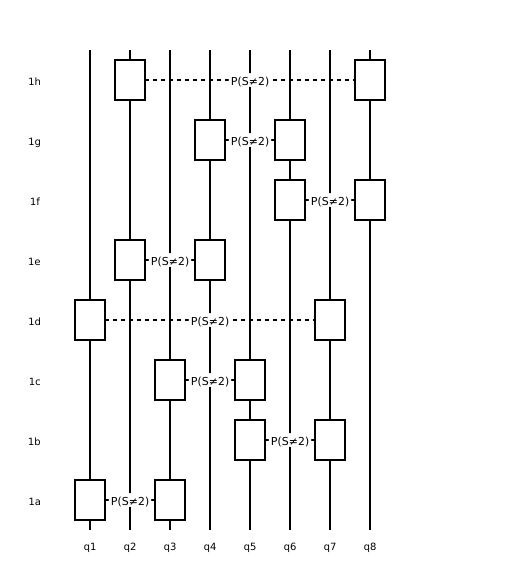

In [22]:
# ASCII visualization (no dependencies)
# print_circuit(circuit_A)

# SVG export (requires Luxor.jl)
using Luxor
plot_circuit(circuit_A; seed=3, )

## Parameter Sweep: Order Parameter and Entanglement Entropy

Compute the string order parameter and entanglement entropy for different system sizes (L) and NN probabilities (p_nn).

**Goal**: Map out how these observables depend on the NN/NNN mixing ratio across system sizes.

In [5]:
# Parameter sweep over L, p_nn, and random seeds
L_list = [8, 16]
p_list = range(0, 1.01, step=0.1) |> collect  # [0.0, 0.1, ..., 1.0]
seed_list = 1:10  # Random seeds for averaging

# Store results: Dict[(L, p_nn)] => (entropy_mean, entropy_std, so_mean, so_std)
results = Dict{Tuple{Int, Float64}, NamedTuple{(:S_mean, :S_std, :SO_mean, :SO_std), NTuple{4, Float64}}}()

println("═"^70)
println("Parameter Sweep with Seed Averaging")
println("  L ∈ $L_list")
println("  p_nn ∈ [0, 1] (step 0.1)")
println("  seeds ∈ $(seed_list)")
println("═"^70)
println()

for L in L_list
    println("─"^50)
    println("System size L = $L")
    println("─"^50)
    
    n_layers = L  # Scale layers with system size for convergence
    
    for p in p_list
        # Collect results across seeds
        S_samples = Float64[]
        SO_samples = Float64[]
        
        for seed in seed_list
            # Create circuit with parameterized API
            circuit = Circuit(L=L, bc=bc, n_steps=1, p_nn=p, proj_gate=proj_gate) do c
                apply_with_prob!(c; rng=:ctrl, outcomes=[
                    (probability=c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nn)),
                    (probability=1-c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nnn))
                ])
            end
            
            # Initialize fresh state with seed-dependent RNG
            rng_reg = RNGRegistry(ctrl=seed, proj=seed+100, haar=seed+200, born=seed+300)
            state = SimulationState(L=L, bc=bc, site_type="S=1", maxdim=maxdim, rng=rng_reg)
            state.mps = MPS(state.sites, ["Z0" for _ in 1:L])
            
            # Track observables (order=2 for pure NNN, order=1 otherwise)
            so_order = p == 0.0 ? 2 : 1
            track!(state, :entropy => EntanglementEntropy(cut=L÷2, order=1, base=2))
            track!(state, :string_order => StringOrder(1, L÷2+1, order=so_order))
            
            # Run simulation
            simulate!(circuit, state; n_circuits=n_layers, record_when=:final_only)
            
            # Collect samples
            push!(S_samples, state.observables[:entropy][end])
            push!(SO_samples, abs(state.observables[:string_order][end]))
        end
        
        # Compute mean and std
        S_mean = mean(S_samples)
        S_std = std(S_samples)
        SO_mean = mean(SO_samples)
        SO_std = std(SO_samples)
        
        # Store results
        results[(L, p)] = (S_mean=S_mean, S_std=S_std, SO_mean=SO_mean, SO_std=SO_std)
        
        @printf("  p_nn = %.1f: S = %.4f ± %.4f, |SO| = %.4f ± %.4f\n", p, S_mean, S_std, SO_mean, SO_std)
    end
    println()
end

println("✓ Parameter sweep complete!")
println("  Total configurations: $(length(results))")
println("  Samples per config: $(length(seed_list))")

══════════════════════════════════════════════════════════════════════
Parameter Sweep: L ∈ [8], p_nn ∈ [0, 1] (step 0.1)
══════════════════════════════════════════════════════════════════════

──────────────────────────────────────────────────
System size L = 8
──────────────────────────────────────────────────
  p_nn = 0.0: S = 3.7818, |SO| = 0.2268
  p_nn = 0.1: S = 3.7818, |SO| = 0.1134
  p_nn = 0.2: S = 4.1884, |SO| = 0.2949
  p_nn = 0.3: S = 4.1884, |SO| = 0.2949
  p_nn = 0.4: S = 2.0016, |SO| = 0.4450
  p_nn = 0.5: S = 2.0016, |SO| = 0.4450
  p_nn = 0.6: S = 2.0017, |SO| = 0.4450
  p_nn = 0.7: S = 2.0017, |SO| = 0.4450
  p_nn = 0.8: S = 2.0017, |SO| = 0.4450
  p_nn = 0.9: S = 2.0017, |SO| = 0.4450
  p_nn = 1.0: S = 1.9987, |SO| = 0.4449

✓ Parameter sweep complete!
  Total configurations: 11


In [6]:
# Display results as formatted tables
println("═"^70)
println("Results Summary (mean ± std over $(length(seed_list)) seeds)")
println("═"^70)
println()

for L in L_list
    println("L = $L:")
    println("┌" * "─"^8 * "┬" * "─"^18 * "┬" * "─"^18 * "┐")
    println("│ p_nn   │    Entropy       │      |SO|        │")
    println("├" * "─"^8 * "┼" * "─"^18 * "┼" * "─"^18 * "┤")
    
    for p in p_list
        r = results[(L, p)]
        @printf("│  %.1f   │ %6.4f ± %6.4f │ %6.4f ± %6.4f │\n", 
                p, r.S_mean, r.S_std, r.SO_mean, r.SO_std)
    end
    
    println("└" * "─"^8 * "┴" * "─"^18 * "┴" * "─"^18 * "┘")
    println()
end

# Physics reference values
println("Reference values (theoretical):")
println("  p_nn = 1.0 (pure NN):  S ≈ 2.0, |SO| ≈ 4/9 ≈ 0.444")
println("  p_nn = 0.0 (pure NNN): S ≈ 4.0, |SO| ≈ (4/9)² ≈ 0.198")

══════════════════════════════════════════════════════════════════════
Results Summary
══════════════════════════════════════════════════════════════════════

L = 8:
┌────────┬────────────┬────────────┐
│ p_nn   │  Entropy   │   |SO|     │
├────────┼────────────┼────────────┤
│  0.0   │   3.7818   │   0.2268   │
│  0.1   │   3.7818   │   0.1134   │
│  0.2   │   4.1884   │   0.2949   │
│  0.3   │   4.1884   │   0.2949   │
│  0.4   │   2.0016   │   0.4450   │
│  0.5   │   2.0016   │   0.4450   │
│  0.6   │   2.0017   │   0.4450   │
│  0.7   │   2.0017   │   0.4450   │
│  0.8   │   2.0017   │   0.4450   │
│  0.9   │   2.0017   │   0.4450   │
│  1.0   │   1.9987   │   0.4449   │
└────────┴────────────┴────────────┘

Reference values (theoretical):
  p_nn = 1.0 (pure NN):  S ≈ 2.0, |SO| ≈ 4/9 ≈ 0.444
  p_nn = 0.0 (pure NNN): S ≈ 4.0, |SO| ≈ (4/9)² ≈ 0.198
│  0.1   │   3.7818   │   0.1134   │
│  0.2   │   4.1884   │   0.2949   │
│  0.3   │   4.1884   │   0.2949   │
│  0.4   │   2.0016   │   

### Interpreting the Results

**Expected behavior:**
- **p_nn = 1.0** (pure NN): Converges to single AKLT chain. S ≈ 2.0, |SO| ≈ 4/9 ≈ 0.444
- **p_nn = 0.0** (pure NNN): Creates two decoupled AKLT chains. S ≈ 4.0, |SO| ≈ (4/9)² ≈ 0.198
- **0 < p_nn < 1** (mixed): Interpolates between these limits

**Note**: The crossover behavior between NN and NNN regimes depends on the competition between these two types of projections.

## Visualization: Order Parameters and Entanglement Entropy

Plot the results with gradient colors for different system sizes.

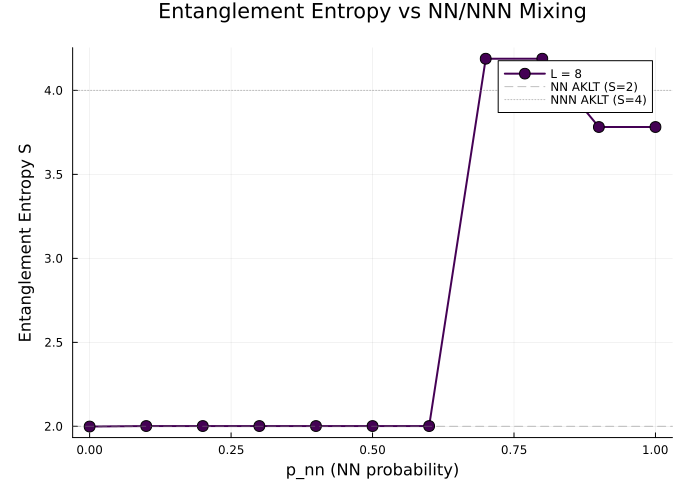

Plotting Entanglement Entropy vs p_nn...


In [17]:
# Plot Entanglement Entropy vs p_nn with error bars
println("Plotting Entanglement Entropy vs p_nn...")

n_L = length(L_list)
colors = cgrad(:viridis, n_L, categorical=true)

p_ee = plot(
    xlabel="p_nn (NN probability)",
    ylabel="Entanglement Entropy S",
    title="Entanglement Entropy vs NN/NNN Mixing",
    legend=:topright,
    grid=true,
    size=(700, 500),
    margin=5Plots.mm
)

for (i, L) in enumerate(L_list)
    p_vals = Float64[]
    S_vals = Float64[]
    S_errs = Float64[]
    for p in p_list
        push!(p_vals, p)
        push!(S_vals, results[(L, p)].S_mean)
        push!(S_errs, results[(L, p)].S_std)
    end
    plot!(p_ee, p_vals, S_vals,
        ribbon=S_errs,
        fillalpha=0.2,
        label="L = $L",
        color=colors[i],
        linewidth=2,
        marker=:circle,
        markersize=5
    )
end

# Add reference lines
hline!(p_ee, [2.0], linestyle=:dash, color=:gray, alpha=0.5, label="NN AKLT (S=2)")
hline!(p_ee, [4.0], linestyle=:dot, color=:gray, alpha=0.5, label="NNN AKLT (S=4)")

display(p_ee)
# savefig(p_ee, "entropy_vs_p.png")

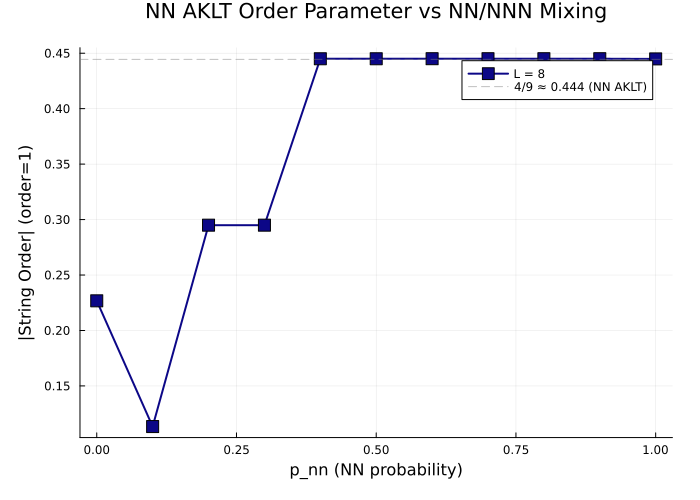

Plotting NN AKLT Order Parameter vs p_nn...


In [8]:
# Plot NN AKLT String Order Parameter vs p_nn with error bars
println("Plotting NN AKLT Order Parameter vs p_nn...")

colors = cgrad(:plasma, length(L_list), categorical=true)

p_nn_op = plot(
    xlabel="p_nn (NN probability)",
    ylabel="|String Order| (order=1)",
    title="NN AKLT Order Parameter vs NN/NNN Mixing",
    legend=:topright,
    grid=true,
    size=(700, 500),
    margin=5Plots.mm
)

for (i, L) in enumerate(L_list)
    p_vals = Float64[]
    SO_vals = Float64[]
    SO_errs = Float64[]
    for p in p_list
        push!(p_vals, p)
        push!(SO_vals, results[(L, p)].SO_mean)
        push!(SO_errs, results[(L, p)].SO_std)
    end
    plot!(p_nn_op, p_vals, SO_vals,
        ribbon=SO_errs,
        fillalpha=0.2,
        label="L = $L",
        color=colors[i],
        linewidth=2,
        marker=:square,
        markersize=5
    )
end

# Add reference line for expected NN AKLT value
hline!(p_nn_op, [4/9], linestyle=:dash, color=:gray, alpha=0.5, label="4/9 ≈ 0.444 (NN AKLT)")

display(p_nn_op)
# savefig(p_nn_op, "nn_order_vs_p.png")

In [9]:
# Compute NNN AKLT Order Parameter (order=2 formula) with seed averaging
println("═"^70)
println("Computing NNN String Order (order=2) for all (L, p_nn, seed)...")
println("═"^70)

results_nnn = Dict{Tuple{Int, Float64}, NamedTuple{(:mean, :std), Tuple{Float64, Float64}}}()

for L in L_list
    n_layers = L
    
    for p in p_list
        SO_samples = Float64[]
        
        for seed in seed_list
            # Create circuit
            circuit = Circuit(L=L, bc=bc, n_steps=1, p_nn=p, proj_gate=proj_gate) do c
                apply_with_prob!(c; rng=:ctrl, outcomes=[
                    (probability=c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nn)),
                    (probability=1-c.params[:p_nn], gate=c.params[:proj_gate], geometry=Bricklayer(:nnn))
                ])
            end
            
            # Initialize fresh state with seed-dependent RNG
            rng_reg = RNGRegistry(ctrl=seed, proj=seed+100, haar=seed+200, born=seed+300)
            state = SimulationState(L=L, bc=bc, site_type="S=1", maxdim=maxdim, rng=rng_reg)
            state.mps = MPS(state.sites, ["Z0" for _ in 1:L])
            
            # Track NNN string order (order=2)
            track!(state, :string_order_nnn => StringOrder(1, L÷2+1, order=2))
            
            # Run simulation
            simulate!(circuit, state; n_circuits=n_layers, record_when=:final_only)
            
            # Collect sample
            push!(SO_samples, abs(state.observables[:string_order_nnn][end]))
        end
        
        # Store mean and std
        results_nnn[(L, p)] = (mean=mean(SO_samples), std=std(SO_samples))
    end
    @printf("  L = %d: done\n", L)
end
println("✓ NNN order parameter sweep complete!")

══════════════════════════════════════════════════════════════════════
Computing NNN String Order (order=2) for all (L, p_nn)...
══════════════════════════════════════════════════════════════════════
  L = 8: done
✓ NNN order parameter sweep complete!
  L = 8: done
✓ NNN order parameter sweep complete!


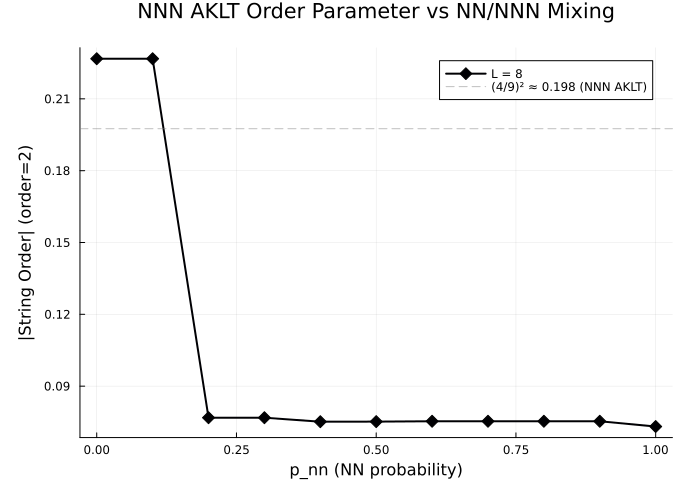

Plotting NNN AKLT Order Parameter vs p_nn...


In [10]:
# Plot NNN AKLT String Order Parameter vs p_nn with error bars
println("Plotting NNN AKLT Order Parameter vs p_nn...")

colors = cgrad(:inferno, length(L_list), categorical=true)

p_nnn_op = plot(
    xlabel="p_nn (NN probability)",
    ylabel="|String Order| (order=2)",
    title="NNN AKLT Order Parameter vs NN/NNN Mixing",
    legend=:topright,
    grid=true,
    size=(700, 500),
    margin=5Plots.mm
)

for (i, L) in enumerate(L_list)
    p_vals = Float64[]
    SO_vals = Float64[]
    SO_errs = Float64[]
    for p in p_list
        push!(p_vals, p)
        push!(SO_vals, results_nnn[(L, p)].mean)
        push!(SO_errs, results_nnn[(L, p)].std)
    end
    plot!(p_nnn_op, p_vals, SO_vals,
        ribbon=SO_errs,
        fillalpha=0.2,
        label="L = $L",
        color=colors[i],
        linewidth=2,
        marker=:diamond,
        markersize=5
    )
end

# Add reference line for expected NNN AKLT value
hline!(p_nnn_op, [(4/9)^2], linestyle=:dash, color=:gray, alpha=0.5, label="(4/9)² ≈ 0.198 (NNN AKLT)")

display(p_nnn_op)
# savefig(p_nnn_op, "nnn_order_vs_p.png")

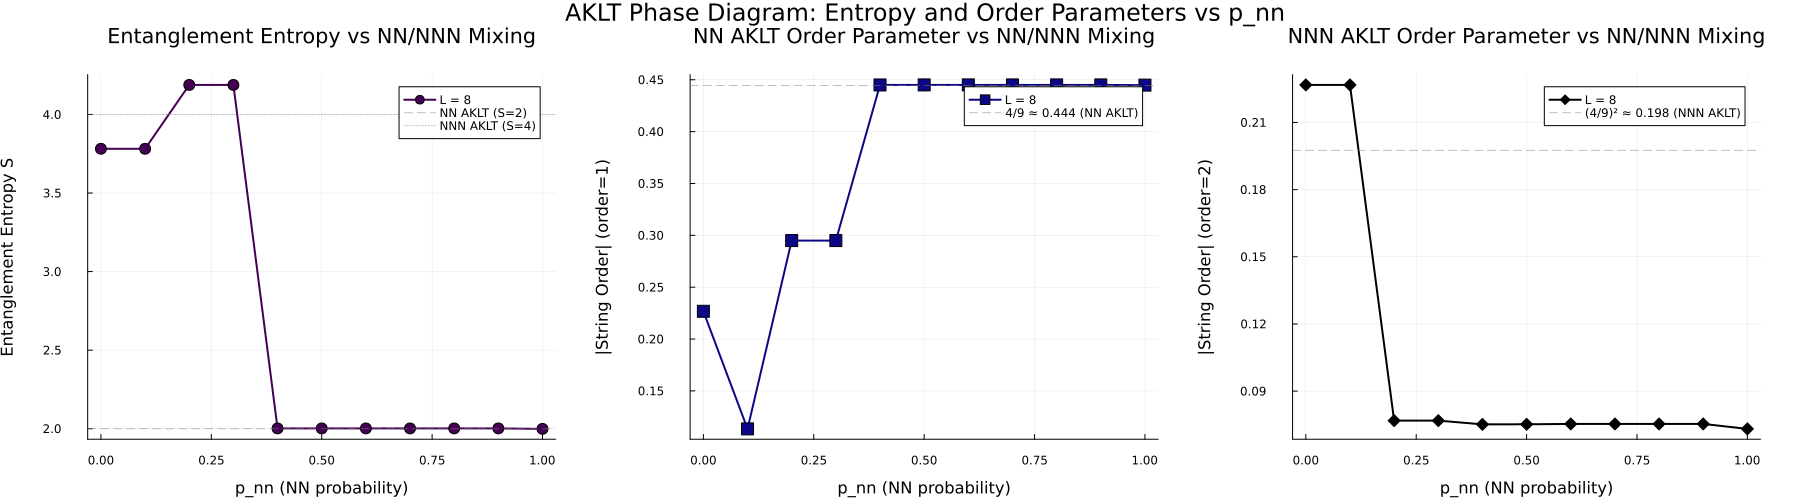

Creating combined plot...

✓ All plots generated!
  Uncomment savefig() lines to save plots to files.

✓ All plots generated!
  Uncomment savefig() lines to save plots to files.


In [11]:
# Combined subplot: All three observables
println("Creating combined plot...")

p_combined = plot(p_ee, p_nn_op, p_nnn_op,
    layout=(1, 3),
    size=(1800, 500),
    margin=8Plots.mm,
    plot_title="AKLT Phase Diagram: Entropy and Order Parameters vs p_nn"
)

display(p_combined)
# savefig(p_combined, "aklt_phase_diagram.png")

println("\n✓ All plots generated!")
println("  Uncomment savefig() lines to save plots to files.")

In [ ]:
k